# ResNet14를 활용한 알약 구별 프로젝트

준비물 : train과 test폴더에 각 클래스별로 구별된 이미지 파일들이 필요하다

In [17]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

파일을 매번 다운로드하면 많은 시간이 소요되므로, 구글 드라이브를 마운트하여 구글 드라이브의 이미지 파일들을 가져온다

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


plt로 알약의 이름값을 확인할때, 한글 폰트를 적용시키고자 하였으나 내부적 문제로 우선 영어로 사용한다

In [19]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
#plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [20]:
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import os

  import torchvision
  from torchvision import datasets, models, transforms

  import numpy as np
  import time


  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

학습의 정확도를 높이기 위해 데이터 증진 작업을 거친다

In [21]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './drive/MyDrive/pill_data'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 2721
테스트 데이터셋 크기: 1167
클래스: ['Gelusam Tab', 'Myambutol Tab', 'Timing Tab']


In [22]:
print(class_names)

['Gelusam Tab', 'Myambutol Tab', 'Timing Tab']


이미지를 제대로 불러왔는지 아래 함수를 통해 확인이 가능하다

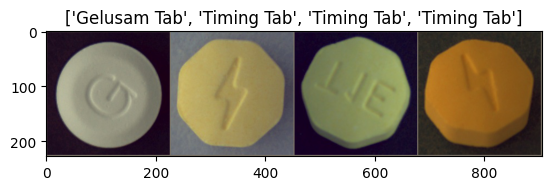

In [23]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

학습 모델을 만들기 위해 ResNet18모델을 받아온다. resnet18의 매개변수값으로 weight을 넣어주어야 한다

In [24]:
from torchvision.models.resnet import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

아래 코드를 이용하여 학습을 진행한다. epochs는 각 이미지당 학습 횟수를 의미하고, Acc는 각 학습에서의 정확도를 의미한다

In [25]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.1786 Acc: 93.8625% Time: 14.4233s
#1 Loss: 0.1257 Acc: 96.6556% Time: 28.6563s
#2 Loss: 0.0975 Acc: 97.2437% Time: 42.6508s
#3 Loss: 0.0752 Acc: 97.9052% Time: 56.6379s
#4 Loss: 0.0677 Acc: 97.7582% Time: 70.6168s
#5 Loss: 0.0491 Acc: 98.1992% Time: 84.6028s
#6 Loss: 0.0221 Acc: 99.3017% Time: 98.6134s
#7 Loss: 0.0093 Acc: 99.6692% Time: 112.6194s
#8 Loss: 0.0067 Acc: 99.8530% Time: 126.5777s
#9 Loss: 0.0042 Acc: 99.9632% Time: 140.5507s
#10 Loss: 0.0023 Acc: 100.0000% Time: 154.5346s
#11 Loss: 0.0016 Acc: 100.0000% Time: 168.6247s
#12 Loss: 0.0017 Acc: 100.0000% Time: 182.6206s
#13 Loss: 0.0015 Acc: 100.0000% Time: 196.6003s
#14 Loss: 0.0010 Acc: 100.0000% Time: 210.5662s
#15 Loss: 0.0013 Acc: 100.0000% Time: 224.5367s
#16 Loss: 0.0014 Acc: 100.0000% Time: 238.5787s
#17 Loss: 0.0009 Acc: 100.0000% Time: 252.5635s
#18 Loss: 0.0010 Acc: 100.0000% Time: 266.5376s
#19 Loss: 0.0008 Acc: 100.0000% Time: 280.5248s
#20 Loss: 0.0010 Acc: 100.0000% Time: 294.5208s
#21 Loss: 0.0006 Ac

test폴더의 데이터를 바탕으로 만들어진 모델의 정확도를 확인한다

In [ ]:
# 모델 평가
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    correct = 0
    false = 0
    i = 0 # 100개만 테스트 하기 위해
    for inputs, labels in test_dataloader:

        if i==1000:
          break
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        #print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # 예측 결과 / 실제 정답
        if class_names[preds[0]] == class_names[labels.data[0]]:
          correct += 1
        else:
          false += 1
        imshow(inputs.cpu().data[0], title=f'{i} : [predict: {class_names[preds[0]]}/result: {class_names[labels.data[0]]}]')
        i+=1

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
    print(f'correct : {correct} false : {false}')

Output hidden; open in https://colab.research.google.com to view.

아래 코드를 통해 만들어진 인공지능 모델을 다운할수 있다. 확장자는 주로 pt나 pth로 다운된다

In [ ]:
!pwd

/content


In [27]:
import torch

# 모델 저장 => 구글 코랩에 다운되므로, 백업을 해야한다.
torch.save(model.state_dict(), 'resnet18_test2.pth')


인공지능 모델 로드하는 방법 => 좀더 구체적인 실험 필요

In [56]:
import torch
import torch.nn.functional as F

# 모델 매개변수 로드
model_parameters = torch.load('resnet18_test2.pth')

# 새로운 모델 생성 => resnet18로 학습되었으므로, 기반 모델로 18로
model = torchvision.models.resnet18()

# 마지막 층의 출력 뉴런 수 변경 => 512는 resnet18의 마지막 레이어의 번호를 의미(마지막 레이어에서 뉴런 3개 이용?한것이므로)
model.fc = nn.Linear(512, 3) # 3은 학습한 객체를 의미

# 모델 매개변수 로드
model.load_state_dict(model_parameters)

# 모델을 평가 모드로 설정
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

모델 정확도 검증하는 방법 => model_test_images에 저장한 이미지들을 바탕으로 정확도를 측정한다

['test_pill.jpg', 'test2.png', 'Timing_test1.png', 'Timing_test2.png', 'Timing_test3.png', 'Myambutol_test1.png', 'Myambutol_test2.png', 'tilenole.png', 'm_test2.png', 'm_test1.png', 't_test1.png', 't_test3.png']


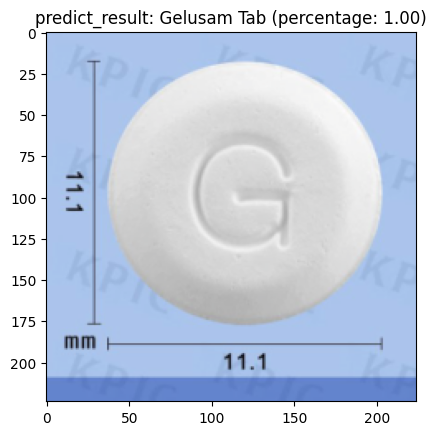

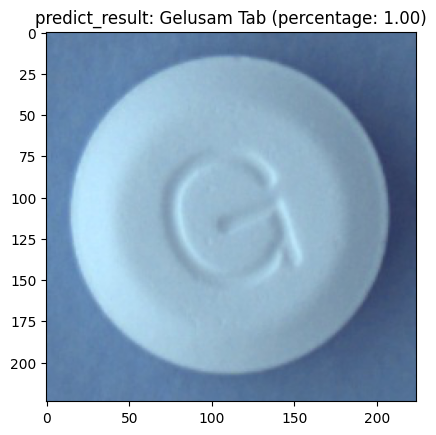

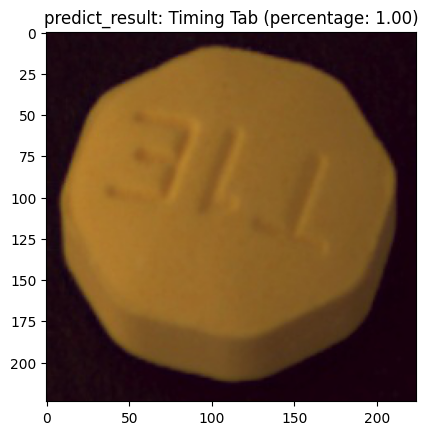

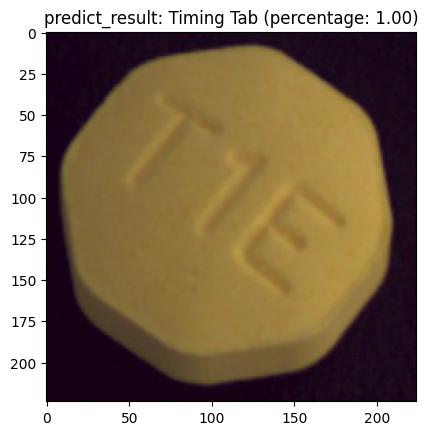

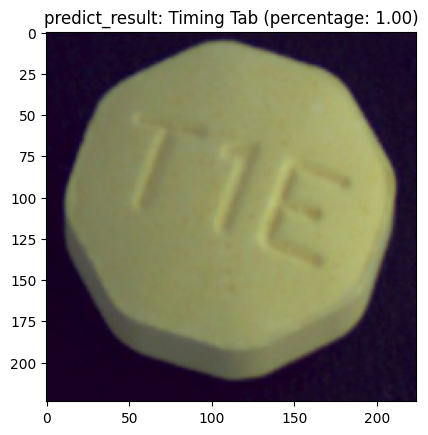

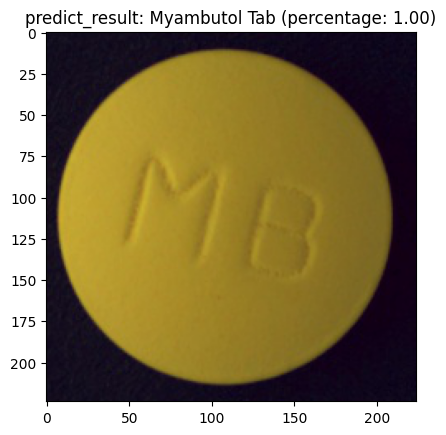

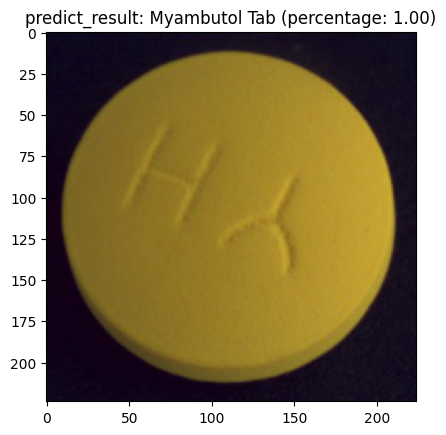

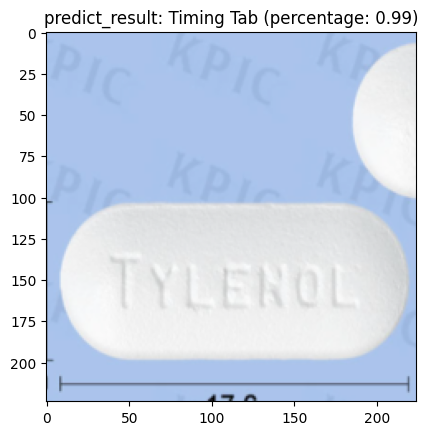

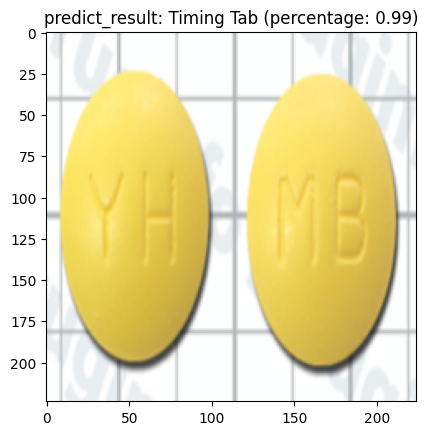

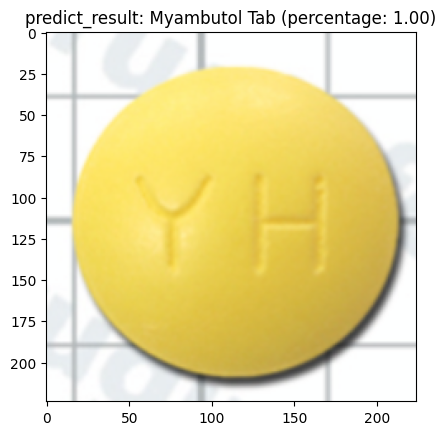

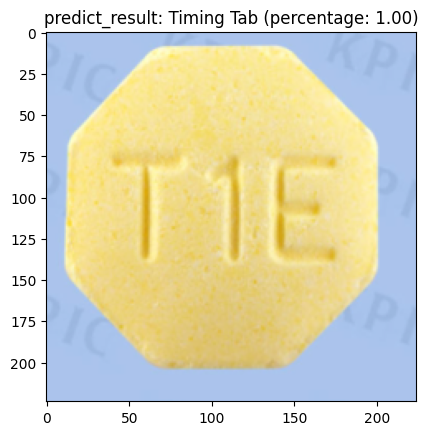

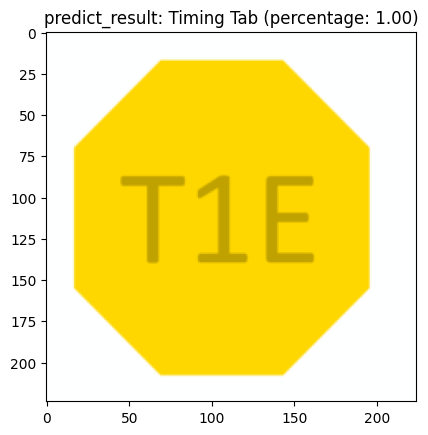

In [51]:
# 모델 정확도 검증
from PIL import Image
import torch.nn.functional as F


# model_test_images에 저장한 이미지들의 이름을 불러온다
folder_dir = r'./drive/MyDrive/model_test_images'
image_lists = os.listdir(folder_dir)

print(image_lists)


# 불러온 이미지 수만큼 모델로 테스트하여 정확도를 검정한다.
for i in range(len(image_lists)):
  image = Image.open('./drive/MyDrive/model_test_images/' + image_lists[i])
  image = transforms_test(image).unsqueeze(0).to(device)
  model.to(device)  # 모델을 동일한 디바이스로 이동시킴

  with torch.no_grad():
      outputs = model(image)
      probabilities = F.softmax(outputs, dim=1)  # 예측 결과를 확률로 변환
      _, preds = torch.max(outputs, 1)
      predicted_class = class_names[preds[0]]
      predicted_prob = probabilities[0, preds[0]].item()  # 예측된 클래스의 확률 값

  imshow(image.cpu().data[0], title=f'predict_result: {predicted_class} (percentage: {predicted_prob:.2f})')